In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r 'drive/My Drive/Colab Notebooks/data/SP500.csv' ./

In [3]:
import os
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'rb').read()
    data = f.decode().split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row),:]
    np.random.shuffle(train)
    x_train = train[:,:-1]
    y_train = train[:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers):
    model = Sequential()

    model.add(LSTM(input_shape = (layers[1], layers[0]),
                    output_dim=layers[1],
                    return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(layers[2],return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer='rmsprop')
    print(" 実行時間：　", time.time() - start)
    return model

def predict_point_by_point(model, data):
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs


Using TensorFlow backend.


In [0]:
import time

In [0]:
import matplotlib.pyplot as plt

In [0]:
def plot_results_multiple(predicted_data,true_data,prediction_len):
  fig = plt.figure(facecolor='white')
  ax = fig.add_subplot(111)
  ax.plot(true_data,label='True Data')
  for i ,data in enumerate(predicted_data):
    padding = [None for p in range(i * prediction_len)]
    plt.plot(padding + data, label = 'Prediction')
  plt.show()

In [0]:
epoch = 1
seq_len = 50

In [0]:
X_train,y_train,X_test,y_test = load_data('SP500.csv',seq_len,True)

In [31]:
model = lstm.build_model([1,50,100,1])

 実行時間：　 0.00845956802368164


In [32]:
model.fit(X_train,y_train,batch_size=512,nb_epoch=epoch,validation_split=0.05)

Train on 3523 samples, validate on 186 samples
Epoch 1/1
3523/3523 [==============================] - 5s 1ms/step - loss: 0.0023 - val_loss: 8.5846e-04


In [0]:
predictions = lstm.predict_sequences_multiple(model,X_test,seq_len,50)

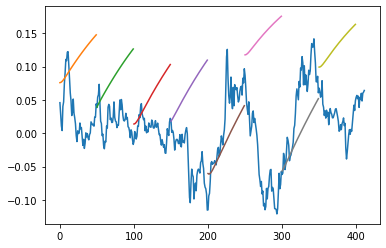

In [37]:
plot_results_multiple(predictions,y_test,50)